# Base de Dados Iris
Identificar espécie de flor com base nas dimensões da pétala e sépala

### Proposta:
Combinar os modelos de classificação

In [12]:
# =====   Importação das Bibliotecas   ===== #
from pandas import read_csv, DataFrame, Series
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder

# Desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Cria os modelos que mostraram ter melhor precisão
def create_models():
    rna_model = MLPClassifier(max_iter=1000, tol=0.000001, solver='adam',
                           hidden_layer_sizes=(100), activation='relu',
                           batch_size=200, learning_rate_init=0.001)
    rna_model.fit(previsores, classe)

    svm_model = SVC(kernel='rbf', random_state=1, C=2.0, gamma='auto')
    svm_model.fit(previsores, classe)

    knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
    knn_model.fit(previsores, classe)
    
    return rna_model, svm_model, knn_model

In [14]:
# Salva os modelos de classificação em disco
def save_models(modelos, nomes):
    for modelo, nome in zip(modelos, nomes):
        arquivo = nome + '.sav'
        pickle.dump(modelo, open(arquivo, 'wb'))

In [22]:
def analiza_registro(registro, nome_modelo):
    # Realiza as previsoes para cada um dos modelos
    # retorna as previsoes em um DataFrame
    dados = np.zeros((len(registro), len(nome_modelo)))
    previsoes = DataFrame(dados, columns=nome_modelo)

    for modelo, nome in zip(classificadores, nome_modelo):
        #print(modelo.predict(registro))
        previsoes[nome] = modelo.predict(registro)
    
    return previsoes

In [16]:
def combine_models(previsoes):
    # Define a classe do registro combinando as previsoes
    # utiliza o metodo de pluralidade (mais votos)
    # retorna as classificacoes definidas pelo metodo e
    #         os registros concatenanto as classificacoes com os atributos
    classificacoes = np.zeros(len(previsoes))
    classificacoes = classificacoes.reshape(-1,1)

    for i in range(len(previsoes)):
        lista = previsoes.iloc[i].values
        elemento, n_repeat = np.unique(lista, return_counts=True)
        aux = dict(zip(n_repeat, elemento))
        classificacoes[i] = aux[max(aux.keys())]
    
    registros = np.concatenate((novo_registro, classificacoes), axis=1)
    
    return registros, classificacoes

In [136]:
# Plotagem dos gráficos de forma padronizada
def plot_graficos(x, y, reg):
    marcadores = ['v', '^', '<', '>', 's', 'P', '*', 'X', 'D', '1', '2', '3', '4', ]
    plt.scatter(iris_setosa[x], iris_setosa[y], color="blue", label="Setosa")
    plt.scatter(iris_versi[x], iris_versi[y], color="green", label="Versicolor")
    plt.scatter(iris_virgi[x], iris_virgi[y], color="red", label="Virginica")
    for n in range(len(reg)):
        if "Iris-setosa" in reg[n:n+1].classe.values:
            plt.scatter(reg[n:n+1][x].values, reg[n:n+1][y].values, color="blue", marker=marcadores[n])
        elif "Iris-versicolor" in reg[n:n+1].classe.values:
            plt.scatter(reg[n:n+1][x].values, reg[n:n+1][y].values, color="green", marker=marcadores[n])
        elif "Iris-virginica" in reg[n:n+1].classe.values:
            plt.scatter(reg[n:n+1][x].values, reg[n:n+1][y].values, color="red", marker=marcadores[n])
    plt.legend()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("{} x {}".format(x,y))
    plt.show()

In [18]:
# Importação da base de dados Iris
base = read_csv("iris.csv")
atributos = list(base.columns)

previsores = base.iloc[:, 0:4].values
classe = base.iloc[:, 4].values
encoder = LabelEncoder()
classe = encoder.fit_transform(classe)

In [19]:
# =====   Criação dos modelos a utilizar   ===== #
list_models = ['modelo_rna', 'modelo_svm', 'modelo_knn']

In [20]:
# OPÇÃO 1:
# Cria os modelos de classificacao e os salva em disco (opcional)
classificadores = create_models()
#save_models(classificadores, nomes=list_models)

In [ ]:
# OPÇÃO 2:
# Carrega os modelo salvos em disco
model_rna = pickle.load(open('modelo_rna.sav', 'rb'))
model_svm = pickle.load(open('modelo_svm.sav', 'rb'))
model_knn = pickle.load(open('modelo_knn.sav', 'rb'))
classificadores = [model_rna, model_svm, model_knn]

In [21]:
# Avaliação dos modelos carregados
precisoes = DataFrame(columns=list_models)
for i in range(len(classificadores)):
    precisoes[list_models[i]] = Series(classificadores[i].score(previsores, classe))

precisoes

,modelo_rna,modelo_svm,modelo_knn
0,0.98,0.993333,0.966667


### Previsões da classificação de cada um dos modelos separados

In [180]:
# =====   Teste de Classificação de novo registro   ===== #
novo_registro = [[6.5, 2.5, 2.2, 0.7], [6.6, 2.1, 4.8, 0.9], [5.5, 2.4, 4.7, 2.0],
                [4.3, 2.2, 4.0, 0.3], [5.7, 3.2, 4.0, 1.6], [6.7, 3.3, 4.3, 1.8], [6.1, 2.2, 5.4, 1.3],
                [5.5, 3.2, 2.3, 0.8], [5.5, 3.2, 2.9, 0.6], [7.7, 3.7, 2.5, 0.8], [6.6, 2.6, 2.5, 0.7]]
novo_registro = np.array(novo_registro)
#novo_registro = previsores
#print(f"Registros a avaliar:\n {novo_registro} ")

# Realização das previsoes
previsoes = analiza_registro(novo_registro, list_models)
previsoes

,modelo_rna,modelo_svm,modelo_knn
0,0,1,0
1,1,1,1
2,2,2,2
3,1,1,1
4,1,1,1
5,1,1,1
6,2,2,2
7,0,0,0
8,0,1,1
9,0,1,0


### Classificação final dos novo registros após combinação dos modelos

In [181]:
# =====   Combinação dos Classificadores   ===== #
registros, _ = combine_models(previsoes)
registros = DataFrame(registros, columns=atributos)
dict_classe = {0: "Iris-setosa", 1: "Iris-versicolor", 2: "Iris-virginica"}
for i in dict_classe.keys():
    registros.loc[registros["class"] == i, "classe"] = dict_classe[i]

registros

,sepal length,sepal width,petal length,petal width,class,classe
0,6.5,2.5,2.2,0.7,0.0,Iris-setosa
1,6.6,2.1,4.8,0.9,1.0,Iris-versicolor
2,5.5,2.4,4.7,2.0,2.0,Iris-virginica
3,4.3,2.2,4.0,0.3,1.0,Iris-versicolor
4,5.7,3.2,4.0,1.6,1.0,Iris-versicolor
5,6.7,3.3,4.3,1.8,1.0,Iris-versicolor
6,6.1,2.2,5.4,1.3,2.0,Iris-virginica
7,5.5,3.2,2.3,0.8,0.0,Iris-setosa
8,5.5,3.2,2.9,0.6,1.0,Iris-versicolor
9,7.7,3.7,2.5,0.8,0.0,Iris-setosa


### Análise dos Resultados Obtidos
Novos registros são exibidos em formatos diferentes e nas cores da classe atribuída a eles

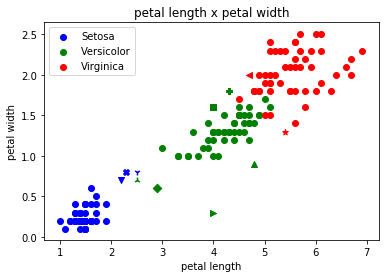

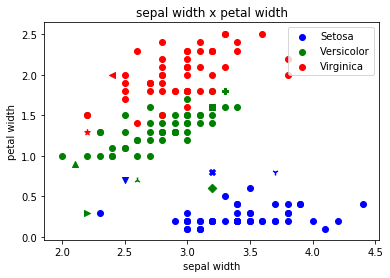

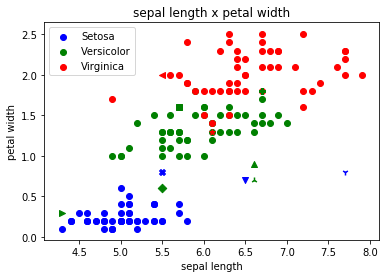

In [182]:
# =====   Analise dos Resultados Obtidos   ===== #
iris_setosa = base.loc[base["class"] == "Iris-setosa"]
iris_versi = base.loc[base["class"] == "Iris-versicolor"]
iris_virgi = base.loc[base["class"] == "Iris-virginica"]

plot_graficos("petal length", "petal width", registros)
plot_graficos("sepal width", "petal width", registros)
plot_graficos("sepal length", "petal width", registros)